In [5]:
from pathlib import Path
import os
import pandas as pd

print("cwd:", os.getcwd())

cwd: /Users/ganeshpokharel/projects/ieee-cis-fraud-detection/notebooks


In [6]:
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("fig dir:", FIG_DIR.resolve())

fig dir: /Users/ganeshpokharel/projects/ieee-cis-fraud-detection/reports/figures


In [7]:
tt = pd.read_csv("../data/raw/ieee-fraud-detection/train_transaction.csv")
ti = pd.read_csv("../data/raw/ieee-fraud-detection/train_identity.csv")

df = tt.merge(ti, on="TransactionID", how="left")

print("train_transaction:", tt.shape)
print("train_identity   :", ti.shape)
print("merged           :", df.shape)
print("fraud rate       :", df["isFraud"].mean())

train_transaction: (590540, 394)
train_identity   : (144233, 41)
merged           : (590540, 434)
fraud rate       : 0.03499000914417313


Loaded train_transaction + train_identity and merged on TransactionID. Fraud rate is about 3.5% (imbalanced).

In [8]:
df[["TransactionID", "TransactionDT", "TransactionAmt", "isFraud"]].head()


,TransactionID,TransactionDT,TransactionAmt,isFraud
0,2987000,86400,68.5,0
1,2987001,86401,29.0,0
2,2987002,86469,59.0,0
3,2987003,86499,50.0,0
4,2987004,86506,50.0,0


In [12]:
counts = df["isFraud"].value_counts()
counts

isFraud
0    569877
1     20663
Name: count, dtype: int64

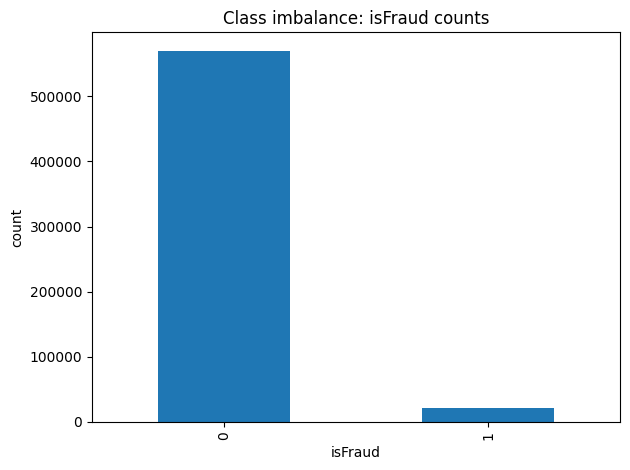

In [13]:
import matplotlib.pyplot as plt

ax = counts.plot(kind="bar")
ax.set_title("Class imbalance: isFraud counts")
ax.set_xlabel("isFraud")
ax.set_ylabel("count")

plt.tight_layout()
plt.savefig(FIG_DIR / "class_imbalance.png", dpi=150)
plt.show()




The dataset is highly imbalanced (fraud = 20,663 vs non-fraud = 569,877). So later I will focus on PR-AUC instead of accuracy.

In [18]:
missing_value = df.isna().mean().sort_values(ascending=False)

print("Top 10 missing columns:")
print(missing_value.head(10))

print("\nColumns with >90% missing_value:", (missing_value > 0.90).sum())


Top 10 missing columns:
id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64

Columns with >90% missing_value: 12


Many identity-related columns have very high missing values. For baseline, I may drop columns with >90% missing.

In [21]:
row_missing = df.isna().mean(axis=1)
row_missing.describe()

count    590540.000000
mean          0.450744
std           0.112986
min           0.055300
25%           0.479263
50%           0.486175
75%           0.527650
max           0.783410
dtype: float64

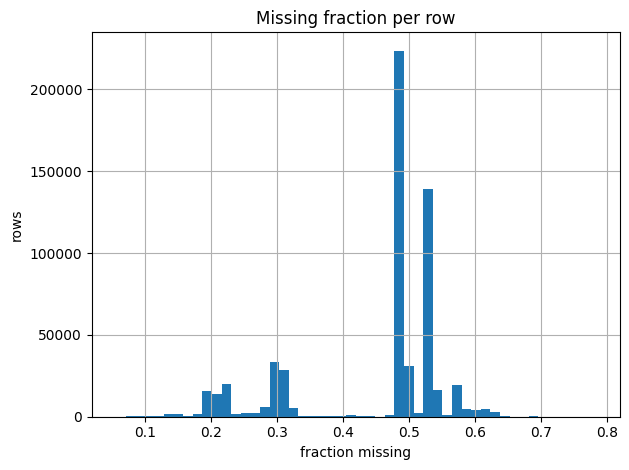

In [22]:
ax = row_missing.hist(bins=50)
ax.set_title("Missing fraction per row")
ax.set_xlabel("fraction missing")
ax.set_ylabel("rows")

plt.tight_layout()
plt.savefig(FIG_DIR / "missing_fraction_per_row.png", dpi=150)
plt.show()

Most rows have around ~48% missing values. Missingness itself might be useful as a feature later.

In [23]:
coverage = df["DeviceType"].notna().mean()
coverage


np.float64(0.23844278118332374)

Only about 24% of rows have DeviceType available, so identity data is sparse.

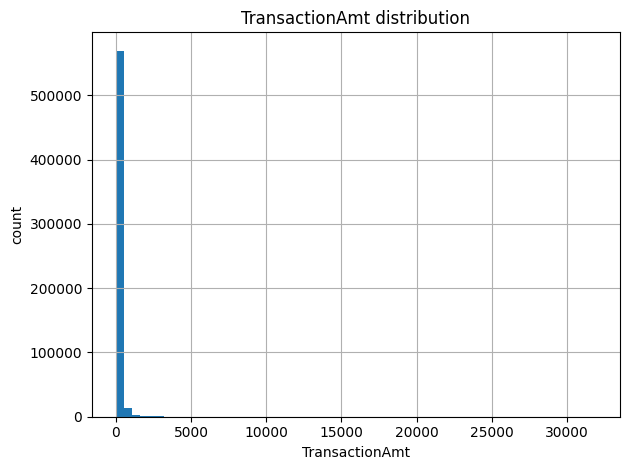

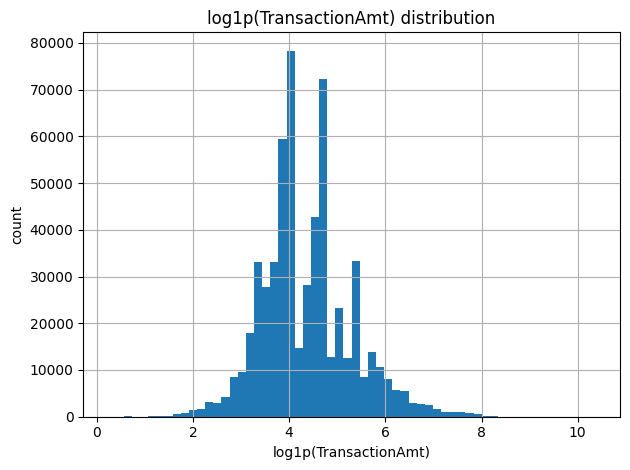

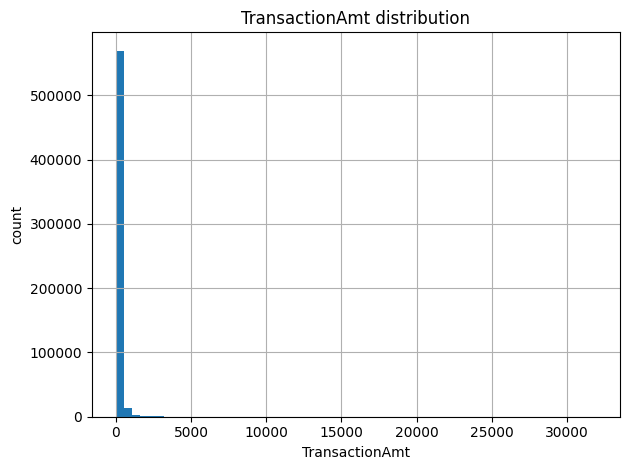

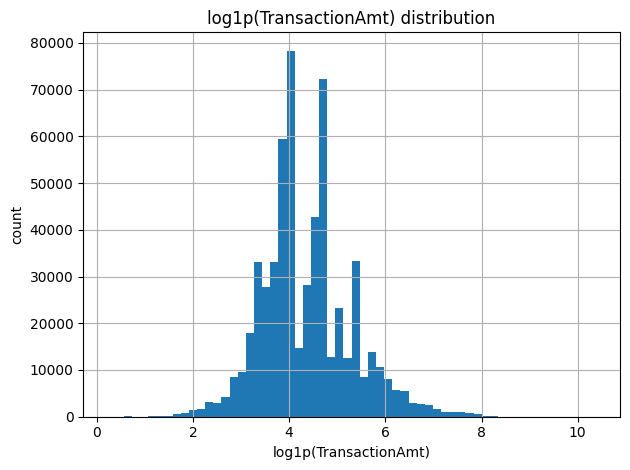

In [26]:
import numpy as np

ax = df["TransactionAmt"].hist(bins=60)
ax.set_title("TransactionAmt distribution")
ax.set_xlabel("TransactionAmt")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "transaction_amt_hist.png", dpi=150)
plt.show()

ax = np.log1p(df["TransactionAmt"]).hist(bins=60)
ax.set_title("log1p(TransactionAmt) distribution")
ax.set_xlabel("log1p(TransactionAmt)")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "transaction_amt_log_hist.png", dpi=150)
plt.show()

ax = df["TransactionAmt"].hist(bins=60)
ax.set_title("TransactionAmt distribution")
ax.set_xlabel("TransactionAmt")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "transaction_amt_hist.png", dpi=150)
plt.show()

ax = np.log1p(df["TransactionAmt"]).hist(bins=60)
ax.set_title("log1p(TransactionAmt) distribution")
ax.set_xlabel("log1p(TransactionAmt)")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "transaction_amt_log_hist.png", dpi=150)
plt.show()


TransactionAmt is very skewed. log1p(TransactionAmt) looks more balanced, so I may use log transform later.

In [27]:
tmp = df[["TransactionDT", "isFraud"]].copy()
tmp["bin"] = pd.cut(tmp["TransactionDT"], bins=50)


In [28]:
g = tmp.groupby("bin")["isFraud"].agg(["count", "mean"]).reset_index()


In [29]:
g[["count","mean"]].describe()

,count,mean
count,50.00000,50.000000
mean,11810.80000,0.035984
std,2619.51241,0.007664
min,8656.00000,0.015484
25%,10235.75000,0.031504
50%,11017.00000,0.035654
75%,12860.50000,0.039457
max,20664.00000,0.059229


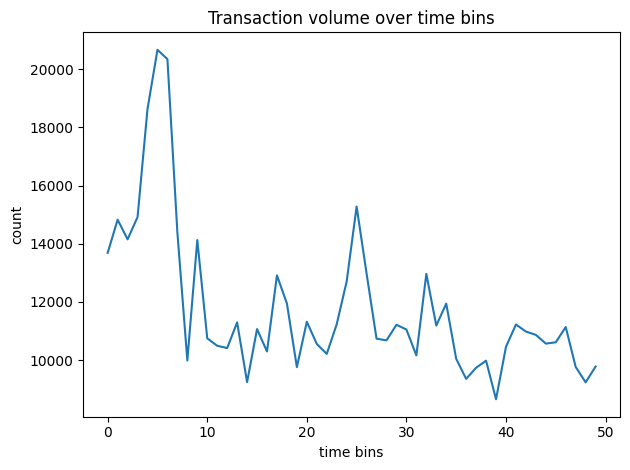

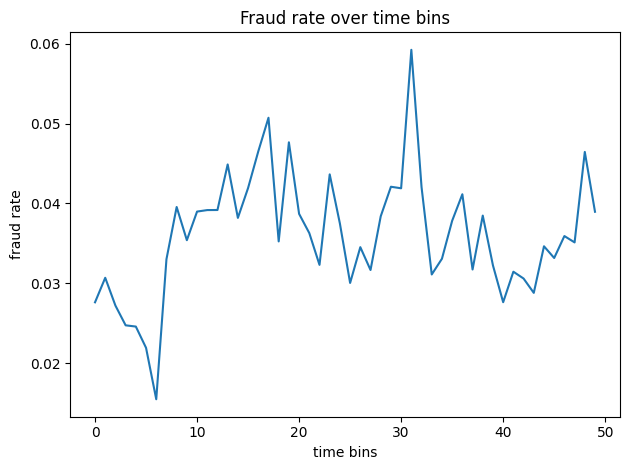

In [30]:
ax = g["count"].plot()
ax.set_title("Transaction volume over time bins")
ax.set_xlabel("time bins")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "volume_over_time.png", dpi=150)
plt.show()

ax = g["mean"].plot()
ax.set_title("Fraud rate over time bins")
ax.set_xlabel("time bins")
ax.set_ylabel("fraud rate")
plt.tight_layout()
plt.savefig(FIG_DIR / "fraud_rate_over_time.png", dpi=150)
plt.show()


Fraud rate changes over time, so I should use a time-based train/validation split to reduce leakage.

In [31]:
tab = df.groupby("ProductCD")["isFraud"].agg(["count", "mean"]).sort_values("count", ascending=False)
tab

,count,mean
ProductCD,,
W,439670,0.020399
C,68519,0.116873
R,37699,0.037826
H,33024,0.047662
S,11628,0.058996


ProductCD categories have very different fraud rates (ex: C is much higher). This feature will be important.

### Summary:

- Merged dataset has 590,540 rows and 434 columns.

- Fraud rate is ~3.5% (highly imbalanced).

- Identity data is sparse (DeviceType available ~24%).

- Some columns have >90% missing (12 columns).

- TransactionAmt is skewed; log1p helps.

- Fraud rate changes over time, so I will use time-based split.

